QFM for targetX

In [1]:
import numpy as np
cutoff_dim=5
r=1.5
val=0.2

target_state=[]
for n in range(cutoff_dim):
    target_state.append((1 / np.sqrt(np.cosh(r)) )*( np.sqrt( np.math.factorial( 2*n )) )/( (2**n)*np.math.factorial(n) )*( np.tanh(r)*np.exp( (-1)**(1/2)*( val + np.pi) ) )**n)
    
target_state

[(0.6519938917982901+0j),
 (-0.4089816533192021-0.08290468546673106j),
 (0.3012915747830949+0.1273840346812343j),
 (-0.223078788697243-0.15261641050806268j),
 (0.1594415209817035+0.1641671375975166j)]

Circuit

In [2]:
import numpy as np
import os
import strawberryfields as sf
from strawberryfields import ops
import tensorflow as tf
import warnings
from itertools import combinations
warnings.filterwarnings("ignore")
physical_devices = tf.config.experimental.list_physical_devices('CPU')
tf.config.experimental.set_visible_devices(physical_devices[0])


def init_weights(modes, layers, active_sd=0.1, passive_sd=1):
    # Number of interferometer parameters:
    M = int(modes * (modes - 1)) 

    # TensorFlow variables
    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    r1_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_mag_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    s_phase_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    r2_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    dp_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, r1_weights, s_mag_weights,s_phase_weights, int2_weights, r2_weights, dr_weights, dp_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

def input_qnn_layer(hid,q):
    with tf.name_scope('inputlayer'):
        ops.Rgate(hid[0]) | q[0]
        ops.Dgate(hid[0]) | q[0]       
        ops.Rgate(hid[0]) | q[0]

# Defining standard QNN layers
def qnn_layer(params,layer_number,q):
    with tf.name_scope('layer_{}'.format(layer_number)):
        N = len(q)
        M = int(modes * (modes - 1)) 
        
        int1 = params[:M]
        r1=params[M:M+N]
        sm = params[M+N:M+2*N]
        sp = params[M+2*N:M+3*N]
        int2 = params[M+3*N:2*M+3*N]
        r2=params[2*M+3*N:2*M+4*N]
        dr = params[2*M+4*N:2*M+5*N]
        dp = params[2*M+5*N:2*M+6*N]
        ker = params[2*M+6*N:2*M+7*N]
        
        theta1=int1[:len(int1)//2]
        phi1=int1[len(int1)//2:]
        
        theta2=int2[:len(int2)//2]
        phi2=int2[len(int2)//2:]
        
        
        
        for k, (q1, q2) in enumerate(combinations(q,2)):
            ops.BSgate(theta1[k], phi1[k]) | (q1, q2)

        for i in range(N):
            ops.Rgate(r1[i]) | q[i]

        for i in range(N):
            ops.Sgate(sm[i],sp[i]) | q[i]

        for k, (q1, q2) in enumerate(combinations(q,2)):
            ops.BSgate(theta2[k], phi2[k]) | (q1, q2)

        for i in range(N):
            ops.Rgate(r2[i]) | q[i]

        for i in range(N):
            ops.Dgate(dr[i], dp[i]) | q[i]

        for i in range(N):
            ops.Kgate(ker[i]) | q[i]


modes=1
layers=4
hidden_units=3


eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim})
qnn = sf.Program(modes)

# initialize QNN weights
weights = init_weights(modes, layers) #TensorFlow weights
num_params = np.prod(weights.shape)   

sf_params = np.arange(num_params).reshape(weights.shape).astype(np.str)
sf_params = np.array([qnn.params(*i) for i in sf_params])

hid_params = np.arange(num_params,num_params+hidden_units).reshape(hidden_units,1).astype(np.str) #to input
hid_params = np.array([qnn.params(*i) for i in hid_params])

with qnn.context as q:
    input_qnn_layer(hid_params,q)
    for k in range(layers):
        qnn_layer(sf_params[k],k, q)

Cost

In [3]:
def cost(weights, val,y):
     
    mapping_wt = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))} #Assigns sf parameters to tf variable
    mapping_hid={p.name: w for p, w in zip(hid_params, [val,val,val] )}  #input data
    mapping_wt.update(mapping_hid) #
    
    results = eng.run(qnn, args=mapping_wt)
    ket = results.state.ket()
    fidelity = tf.abs(tf.reduce_sum(tf.multiply(ket, target_state)))**2
    cost = (fidelity - 1) ** 2
    return cost  


optimizer = tf.keras.optimizers.Adam()

Train

In [4]:
for i in range(1000):
    with tf.GradientTape() as tape:
        loss=cost(weights, val , target_state)
        
    gradients=tape.gradient(loss,weights)
    optimizer.apply_gradients(zip([gradients],[weights]))
    
    if eng.run_progs:
        eng.reset()
    print("loss at iteration {} is {}".format(i,loss))

loss at iteration 0 is 0.37094783782958984
loss at iteration 1 is 0.36531510949134827
loss at iteration 2 is 0.3596602976322174
loss at iteration 3 is 0.3539905548095703


loss at iteration 4 is 0.3483138084411621
loss at iteration 5 is 0.3426382839679718
loss at iteration 6 is 0.3369716703891754
loss at iteration 7 is 0.3313211500644684


loss at iteration 8 is 0.32569220662117004
loss at iteration 9 is 0.3200882375240326
loss at iteration 10 is 0.314510703086853
loss at iteration 11 is 0.30895793437957764


loss at iteration 12 is 0.30342841148376465
loss at iteration 13 is 0.2979196012020111
loss at iteration 14 is 0.2924315929412842


loss at iteration 15 is 0.28696581721305847
loss at iteration 16 is 0.2815268337726593
loss at iteration 17 is 0.2761196196079254
loss at iteration 18 is 0.2707521915435791


loss at iteration 19 is 0.2654331624507904
loss at iteration 20 is 0.26017314195632935
loss at iteration 21 is 0.2549833357334137
loss at iteration 22 is 0.24987627565860748


loss at iteration 23 is 0.24486446380615234
loss at iteration 24 is 0.23996089398860931
loss at iteration 25 is 0.23517806828022003
loss at iteration 26 is 0.23052820563316345


loss at iteration 27 is 0.22602258622646332
loss at iteration 28 is 0.22167125344276428
loss at iteration 29 is 0.2174830585718155
loss at iteration 30 is 0.2134656012058258


loss at iteration 31 is 0.2096247524023056
loss at iteration 32 is 0.20596350729465485
loss at iteration 33 is 0.20248469710350037
loss at iteration 34 is 0.19918707013130188


loss at iteration 35 is 0.19606903195381165
loss at iteration 36 is 0.19312617182731628
loss at iteration 37 is 0.19035257399082184
loss at iteration 38 is 0.18774095177650452


loss at iteration 39 is 0.18528182804584503
loss at iteration 40 is 0.18296490609645844
loss at iteration 41 is 0.18077905476093292
loss at iteration 42 is 0.17871232330799103


loss at iteration 43 is 0.1767522096633911
loss at iteration 44 is 0.1748863160610199
loss at iteration 45 is 0.1731027215719223
loss at iteration 46 is 0.17138931155204773


loss at iteration 47 is 0.16973520815372467
loss at iteration 48 is 0.16813012957572937
loss at iteration 49 is 0.1665647327899933
loss at iteration 50 is 0.16503103077411652


loss at iteration 51 is 0.16352200508117676
loss at iteration 52 is 0.1620318591594696
loss at iteration 53 is 0.1605561226606369
loss at iteration 54 is 0.1590917557477951


loss at iteration 55 is 0.15763570368289948
loss at iteration 56 is 0.15618696808815002
loss at iteration 57 is 0.15474528074264526
loss at iteration 58 is 0.15331032872200012


loss at iteration 59 is 0.1518830955028534
loss at iteration 60 is 0.15046469867229462
loss at iteration 61 is 0.14905695617198944
loss at iteration 62 is 0.14766128361225128


loss at iteration 63 is 0.146279975771904
loss at iteration 64 is 0.14491459727287292
loss at iteration 65 is 0.14356692135334015
loss at iteration 66 is 0.14223834872245789


loss at iteration 67 is 0.1409306675195694
loss at iteration 68 is 0.13964471220970154
loss at iteration 69 is 0.13838106393814087
loss at iteration 70 is 0.13714031875133514


loss at iteration 71 is 0.13592270016670227
loss at iteration 72 is 0.13472801446914673
loss at iteration 73 is 0.13355585932731628
loss at iteration 74 is 0.13240547478199005


loss at iteration 75 is 0.13127626478672028
loss at iteration 76 is 0.13016732037067413
loss at iteration 77 is 0.12907706201076508
loss at iteration 78 is 0.1280050277709961


loss at iteration 79 is 0.12694963812828064
loss at iteration 80 is 0.12591040134429932
loss at iteration 81 is 0.12488570064306259
loss at iteration 82 is 0.12387475371360779


loss at iteration 83 is 0.12287689745426178
loss at iteration 84 is 0.1218915730714798
loss at iteration 85 is 0.12091758847236633
loss at iteration 86 is 0.11995527893304825


loss at iteration 87 is 0.11900380253791809
loss at iteration 88 is 0.11806286871433258
loss at iteration 89 is 0.11713260412216187
loss at iteration 90 is 0.11621297150850296


loss at iteration 91 is 0.11530417203903198
loss at iteration 92 is 0.11440583318471909
loss at iteration 93 is 0.11351755261421204
loss at iteration 94 is 0.11264021694660187


loss at iteration 95 is 0.11177393049001694
loss at iteration 96 is 0.1109175831079483
loss at iteration 97 is 0.11007228493690491
loss at iteration 98 is 0.10923706740140915


loss at iteration 99 is 0.10841257125139236
loss at iteration 100 is 0.10759827494621277
loss at iteration 101 is 0.1067943349480629
loss at iteration 102 is 0.10600019991397858


loss at iteration 103 is 0.10521610826253891
loss at iteration 104 is 0.10444097220897675
loss at iteration 105 is 0.10367541760206223
loss at iteration 106 is 0.10291934013366699


loss at iteration 107 is 0.10217169672250748
loss at iteration 108 is 0.10143285989761353
loss at iteration 109 is 0.10070264339447021
loss at iteration 110 is 0.09998056292533875


loss at iteration 111 is 0.09926694631576538
loss at iteration 112 is 0.0985611230134964
loss at iteration 113 is 0.09786318987607956
loss at iteration 114 is 0.09717315435409546


loss at iteration 115 is 0.09649071842432022
loss at iteration 116 is 0.09581591933965683
loss at iteration 117 is 0.09514881670475006
loss at iteration 118 is 0.0944889634847641


loss at iteration 119 is 0.09383651614189148
loss at iteration 120 is 0.09319127351045609
loss at iteration 121 is 0.09255330264568329
loss at iteration 122 is 0.09192229062318802


loss at iteration 123 is 0.09129815548658371
loss at iteration 124 is 0.09068100154399872
loss at iteration 125 is 0.09007050842046738
loss at iteration 126 is 0.08946672081947327


loss at iteration 127 is 0.088869608938694
loss at iteration 128 is 0.0882791131734848
loss at iteration 129 is 0.08769512921571732
loss at iteration 130 is 0.08711699396371841


loss at iteration 131 is 0.08654536306858063
loss at iteration 132 is 0.08597960323095322
loss at iteration 133 is 0.08542001247406006
loss at iteration 134 is 0.08486652374267578


loss at iteration 135 is 0.08431857079267502
loss at iteration 136 is 0.08377670496702194
loss at iteration 137 is 0.08324047923088074
loss at iteration 138 is 0.08270984143018723


loss at iteration 139 is 0.08218497037887573
loss at iteration 140 is 0.0816655158996582
loss at iteration 141 is 0.08115130662918091
loss at iteration 142 is 0.08064285665750504


loss at iteration 143 is 0.08013967424631119
loss at iteration 144 is 0.0796416699886322
loss at iteration 145 is 0.07914907485246658
loss at iteration 146 is 0.07866168767213821


loss at iteration 147 is 0.07817914336919785
loss at iteration 148 is 0.0777018591761589
loss at iteration 149 is 0.07722972333431244
loss at iteration 150 is 0.07676216214895248


loss at iteration 151 is 0.07630006968975067
loss at iteration 152 is 0.07584242522716522
loss at iteration 153 is 0.07538975775241852
loss at iteration 154 is 0.07494167983531952


loss at iteration 155 is 0.07449847459793091
loss at iteration 156 is 0.0740598663687706
loss at iteration 157 is 0.07362601906061172
loss at iteration 158 is 0.07319663465023041


loss at iteration 159 is 0.07277172058820724
loss at iteration 160 is 0.07235131412744522
loss at iteration 161 is 0.07193535566329956
loss at iteration 162 is 0.07152387499809265


loss at iteration 163 is 0.07111673057079315
loss at iteration 164 is 0.07071397453546524
loss at iteration 165 is 0.07031533867120743
loss at iteration 166 is 0.06992097944021225


loss at iteration 167 is 0.06953109055757523
loss at iteration 168 is 0.06914523988962173
loss at iteration 169 is 0.0687636211514473
loss at iteration 170 is 0.06838583201169968


loss at iteration 171 is 0.06801234930753708
loss at iteration 172 is 0.06764286756515503
loss at iteration 173 is 0.06727723032236099
loss at iteration 174 is 0.06691582500934601


loss at iteration 175 is 0.0665581002831459
loss at iteration 176 is 0.06620446592569351
loss at iteration 177 is 0.06585458666086197
loss at iteration 178 is 0.0655084028840065


loss at iteration 179 is 0.06516630202531815
loss at iteration 180 is 0.0648277997970581
loss at iteration 181 is 0.06449314206838608
loss at iteration 182 is 0.06416219472885132


loss at iteration 183 is 0.06383486837148666
loss at iteration 184 is 0.06351104378700256
loss at iteration 185 is 0.06319095939397812
loss at iteration 186 is 0.06287454813718796


loss at iteration 187 is 0.06256164610385895
loss at iteration 188 is 0.062252290546894073
loss at iteration 189 is 0.06194634363055229
loss at iteration 190 is 0.06164398789405823


loss at iteration 191 is 0.06134476512670517
loss at iteration 192 is 0.06104927510023117
loss at iteration 193 is 0.06075720489025116
loss at iteration 194 is 0.06046837940812111


loss at iteration 195 is 0.06018282100558281
loss at iteration 196 is 0.05990041419863701
loss at iteration 197 is 0.05962143838405609
loss at iteration 198 is 0.05934569984674454


loss at iteration 199 is 0.05907309055328369
loss at iteration 200 is 0.05880379676818848
loss at iteration 201 is 0.058537598699331284
loss at iteration 202 is 0.05827442184090614


loss at iteration 203 is 0.058014366775751114
loss at iteration 204 is 0.057757552713155746
loss at iteration 205 is 0.05750354379415512
loss at iteration 206 is 0.05725274235010147


loss at iteration 207 is 0.05700462684035301
loss at iteration 208 is 0.056759946048259735
loss at iteration 209 is 0.05651766434311867
loss at iteration 210 is 0.05627858266234398


loss at iteration 211 is 0.05604223906993866
loss at iteration 212 is 0.055808816105127335
loss at iteration 213 is 0.05557829514145851
loss at iteration 214 is 0.055350273847579956


loss at iteration 215 is 0.05512532219290733
loss at iteration 216 is 0.05490264296531677
loss at iteration 217 is 0.05468306317925453
loss at iteration 218 is 0.054466065019369125


loss at iteration 219 is 0.054251834750175476
loss at iteration 220 is 0.054039906710386276
loss at iteration 221 is 0.053830716758966446
loss at iteration 222 is 0.05362389609217644


loss at iteration 223 is 0.05341975763440132
loss at iteration 224 is 0.053218208253383636
loss at iteration 225 is 0.05301912501454353
loss at iteration 226 is 0.05282247066497803


loss at iteration 227 is 0.052627962082624435
loss at iteration 228 is 0.052435774356126785
loss at iteration 229 is 0.05224636197090149
loss at iteration 230 is 0.052059173583984375


loss at iteration 231 is 0.051874108612537384
loss at iteration 232 is 0.05169138312339783
loss at iteration 233 is 0.0515110045671463
loss at iteration 234 is 0.05133291706442833


loss at iteration 235 is 0.05115683376789093
loss at iteration 236 is 0.05098285898566246
loss at iteration 237 is 0.05081089586019516
loss at iteration 238 is 0.0506412647664547


loss at iteration 239 is 0.05047376826405525
loss at iteration 240 is 0.05030817538499832
loss at iteration 241 is 0.05014464631676674
loss at iteration 242 is 0.049983248114585876


loss at iteration 243 is 0.049823783338069916
loss at iteration 244 is 0.049666356295347214
loss at iteration 245 is 0.04951071739196777
loss at iteration 246 is 0.049356859177351


loss at iteration 247 is 0.04920509085059166
loss at iteration 248 is 0.04905516281723976
loss at iteration 249 is 0.04890694469213486
loss at iteration 250 is 0.04876047745347023


loss at iteration 251 is 0.04861564561724663
loss at iteration 252 is 0.04847284406423569
loss at iteration 253 is 0.048331744968891144
loss at iteration 254 is 0.04819228872656822


loss at iteration 255 is 0.048054397106170654
loss at iteration 256 is 0.04791828989982605
loss at iteration 257 is 0.04778381064534187
loss at iteration 258 is 0.04765072092413902


loss at iteration 259 is 0.047519501298666
loss at iteration 260 is 0.04738971218466759
loss at iteration 261 is 0.04726170375943184
loss at iteration 262 is 0.047134723514318466


loss at iteration 263 is 0.04700951650738716
loss at iteration 264 is 0.046885743737220764
loss at iteration 265 is 0.04676339402794838
loss at iteration 266 is 0.04664251580834389


loss at iteration 267 is 0.04652295634150505
loss at iteration 268 is 0.046404879540205
loss at iteration 269 is 0.04628821462392807
loss at iteration 270 is 0.0461726151406765


loss at iteration 271 is 0.046058543026447296
loss at iteration 272 is 0.04594573751091957
loss at iteration 273 is 0.045834243297576904
loss at iteration 274 is 0.04572387784719467


loss at iteration 275 is 0.04561499506235123
loss at iteration 276 is 0.04550721123814583
loss at iteration 277 is 0.04540059342980385
loss at iteration 278 is 0.04529501497745514


loss at iteration 279 is 0.04519074782729149
loss at iteration 280 is 0.045087896287441254
loss at iteration 281 is 0.04498586431145668
loss at iteration 282 is 0.04488496482372284


loss at iteration 283 is 0.04478500783443451
loss at iteration 284 is 0.04468649625778198
loss at iteration 285 is 0.04458890110254288
loss at iteration 286 is 0.044492367655038834


loss at iteration 287 is 0.04439671337604523
loss at iteration 288 is 0.04430214688181877
loss at iteration 289 is 0.044208504259586334
loss at iteration 290 is 0.0441160649061203


loss at iteration 291 is 0.04402437061071396
loss at iteration 292 is 0.0439339205622673
loss at iteration 293 is 0.04384411498904228
loss at iteration 294 is 0.04375532269477844


loss at iteration 295 is 0.043667569756507874
loss at iteration 296 is 0.04358052462339401
loss at iteration 297 is 0.04349441081285477
loss at iteration 298 is 0.04340920224785805


loss at iteration 299 is 0.043324872851371765
loss at iteration 300 is 0.043241169303655624
loss at iteration 301 is 0.04315860942006111
loss at iteration 302 is 0.04307665303349495


loss at iteration 303 is 0.04299560934305191
loss at iteration 304 is 0.04291523993015289
loss at iteration 305 is 0.04283575713634491
loss at iteration 306 is 0.04275696352124214


loss at iteration 307 is 0.04267891123890877
loss at iteration 308 is 0.04260141775012016
loss at iteration 309 is 0.04252505302429199
loss at iteration 310 is 0.04244920238852501


loss at iteration 311 is 0.042374029755592346
loss at iteration 312 is 0.04229968413710594
loss at iteration 313 is 0.04222579300403595
loss at iteration 314 is 0.042152851819992065


loss at iteration 315 is 0.042080484330654144
loss at iteration 316 is 0.042008645832538605
loss at iteration 317 is 0.04193747788667679
loss at iteration 318 is 0.041866932064294815


loss at iteration 319 is 0.041797127574682236
loss at iteration 320 is 0.04172788932919502
loss at iteration 321 is 0.04165937006473541
loss at iteration 322 is 0.04159141704440117


loss at iteration 323 is 0.04152388125658035
loss at iteration 324 is 0.04145684093236923
loss at iteration 325 is 0.04139074683189392
loss at iteration 326 is 0.041324879974126816


loss at iteration 327 is 0.04125998169183731
loss at iteration 328 is 0.04119518771767616
loss at iteration 329 is 0.041131239384412766
loss at iteration 330 is 0.04106758162379265


loss at iteration 331 is 0.04100457951426506
loss at iteration 332 is 0.040942203253507614
loss at iteration 333 is 0.04088018462061882
loss at iteration 334 is 0.040818627923727036


loss at iteration 335 is 0.040757596492767334
loss at iteration 336 is 0.040697067975997925
loss at iteration 337 is 0.04063708707690239
loss at iteration 338 is 0.04057753458619118


loss at iteration 339 is 0.04051860421895981
loss at iteration 340 is 0.04045993089675903
loss at iteration 341 is 0.04040177911520004
loss at iteration 342 is 0.040343981236219406


loss at iteration 343 is 0.040286894887685776
loss at iteration 344 is 0.04023008793592453
loss at iteration 345 is 0.04017367959022522
loss at iteration 346 is 0.040117621421813965


loss at iteration 347 is 0.04006222262978554
loss at iteration 348 is 0.040006957948207855
loss at iteration 349 is 0.03995230048894882
loss at iteration 350 is 0.039898090064525604


loss at iteration 351 is 0.039844293147325516
loss at iteration 352 is 0.03979058191180229
loss at iteration 353 is 0.03973757103085518
loss at iteration 354 is 0.03968478739261627


loss at iteration 355 is 0.039632461965084076
loss at iteration 356 is 0.03958062455058098
loss at iteration 357 is 0.03952901065349579
loss at iteration 358 is 0.03947769105434418


loss at iteration 359 is 0.039426784962415695
loss at iteration 360 is 0.03937652334570885
loss at iteration 361 is 0.039326462894678116
loss at iteration 362 is 0.039276618510484695


loss at iteration 363 is 0.039227116852998734
loss at iteration 364 is 0.03917804732918739
loss at iteration 365 is 0.039129335433244705
loss at iteration 366 is 0.039080891758203506


loss at iteration 367 is 0.03903299570083618
loss at iteration 368 is 0.038985058665275574
loss at iteration 369 is 0.03893759846687317
loss at iteration 370 is 0.03889056667685509


loss at iteration 371 is 0.038843657821416855
loss at iteration 372 is 0.038797128945589066
loss at iteration 373 is 0.03875118866562843
loss at iteration 374 is 0.03870544210076332


loss at iteration 375 is 0.03865979611873627
loss at iteration 376 is 0.03861447796225548
loss at iteration 377 is 0.038569629192352295
loss at iteration 378 is 0.03852485492825508


loss at iteration 379 is 0.03848057612776756
loss at iteration 380 is 0.03843655437231064
loss at iteration 381 is 0.038392722606658936
loss at iteration 382 is 0.038349222391843796


loss at iteration 383 is 0.03830602020025253
loss at iteration 384 is 0.03826291859149933
loss at iteration 385 is 0.038220301270484924
loss at iteration 386 is 0.038178086280822754


loss at iteration 387 is 0.038135889917612076
loss at iteration 388 is 0.038094136863946915
loss at iteration 389 is 0.03805278241634369
loss at iteration 390 is 0.038011353462934494


loss at iteration 391 is 0.037970248609781265
loss at iteration 392 is 0.03792940080165863
loss at iteration 393 is 0.037889085710048676
loss at iteration 394 is 0.03784876689314842


loss at iteration 395 is 0.03780891001224518
loss at iteration 396 is 0.03776891157031059
loss at iteration 397 is 0.037729423493146896
loss at iteration 398 is 0.03769013658165932


loss at iteration 399 is 0.03765112906694412
loss at iteration 400 is 0.037612393498420715
loss at iteration 401 is 0.037573955953121185
loss at iteration 402 is 0.03753555938601494


loss at iteration 403 is 0.03749760240316391
loss at iteration 404 is 0.037459731101989746
loss at iteration 405 is 0.0374220609664917
loss at iteration 406 is 0.03738482668995857


loss at iteration 407 is 0.0373477041721344
loss at iteration 408 is 0.03731083124876022
loss at iteration 409 is 0.03727422654628754
loss at iteration 410 is 0.03723761811852455


loss at iteration 411 is 0.037201326340436935
loss at iteration 412 is 0.03716544434428215
loss at iteration 413 is 0.03712967038154602
loss at iteration 414 is 0.03709409758448601


loss at iteration 415 is 0.037058886140584946
loss at iteration 416 is 0.037023622542619705
loss at iteration 417 is 0.036988720297813416
loss at iteration 418 is 0.03695401921868324


loss at iteration 419 is 0.03691946715116501
loss at iteration 420 is 0.03688520938158035
loss at iteration 421 is 0.036851197481155396
loss at iteration 422 is 0.03681740537285805


loss at iteration 423 is 0.036783650517463684
loss at iteration 424 is 0.036750275641679764
loss at iteration 425 is 0.03671707957983017
loss at iteration 426 is 0.03668398782610893


loss at iteration 427 is 0.036651186645030975
loss at iteration 428 is 0.036618441343307495
loss at iteration 429 is 0.03658599033951759
loss at iteration 430 is 0.036553800106048584


loss at iteration 431 is 0.036521829664707184
loss at iteration 432 is 0.03648991882801056
loss at iteration 433 is 0.03645813837647438
loss at iteration 434 is 0.03642677888274193


loss at iteration 435 is 0.03639552369713783
loss at iteration 436 is 0.03636430576443672
loss at iteration 437 is 0.03633339703083038
loss at iteration 438 is 0.03630263730883598


loss at iteration 439 is 0.036272093653678894
loss at iteration 440 is 0.03624165430665016
loss at iteration 441 is 0.03621147572994232
loss at iteration 442 is 0.036181628704071045


loss at iteration 443 is 0.03615168109536171
loss at iteration 444 is 0.03612210974097252
loss at iteration 445 is 0.03609268367290497
loss at iteration 446 is 0.036063384264707565


loss at iteration 447 is 0.036034323275089264
loss at iteration 448 is 0.03600536286830902
loss at iteration 449 is 0.03597670793533325
loss at iteration 450 is 0.03594804182648659


loss at iteration 451 is 0.03591956943273544
loss at iteration 452 is 0.0358913354575634
loss at iteration 453 is 0.03586329147219658
loss at iteration 454 is 0.03583548218011856


loss at iteration 455 is 0.035807687789201736
loss at iteration 456 is 0.03578035160899162
loss at iteration 457 is 0.03575291484594345
loss at iteration 458 is 0.03572564572095871


loss at iteration 459 is 0.03569861128926277
loss at iteration 460 is 0.035671792924404144
loss at iteration 461 is 0.03564491495490074
loss at iteration 462 is 0.03561840578913689


loss at iteration 463 is 0.035592153668403625
loss at iteration 464 is 0.03556584566831589
loss at iteration 465 is 0.035539571195840836
loss at iteration 466 is 0.03551366552710533


loss at iteration 467 is 0.03548801317811012
loss at iteration 468 is 0.0354623943567276
loss at iteration 469 is 0.035436876118183136
loss at iteration 470 is 0.03541161119937897


loss at iteration 471 is 0.035386424511671066
loss at iteration 472 is 0.03536153584718704
loss at iteration 473 is 0.03533661365509033
loss at iteration 474 is 0.03531203418970108


loss at iteration 475 is 0.03528744354844093
loss at iteration 476 is 0.03526315093040466
loss at iteration 477 is 0.03523893281817436
loss at iteration 478 is 0.035214949399232864


loss at iteration 479 is 0.03519079089164734
loss at iteration 480 is 0.035167090594768524
loss at iteration 481 is 0.035143397748470306
loss at iteration 482 is 0.03511996194720268


loss at iteration 483 is 0.03509652987122536
loss at iteration 484 is 0.03507348522543907
loss at iteration 485 is 0.035050470381975174
loss at iteration 486 is 0.035027578473091125


loss at iteration 487 is 0.035004645586013794
loss at iteration 488 is 0.03498201072216034
loss at iteration 489 is 0.03495965152978897
loss at iteration 490 is 0.03493732213973999


loss at iteration 491 is 0.03491508588194847
loss at iteration 492 is 0.0348929725587368
loss at iteration 493 is 0.034871041774749756
loss at iteration 494 is 0.03484920784831047


loss at iteration 495 is 0.03482760116457939
loss at iteration 496 is 0.03480606898665428
loss at iteration 497 is 0.03478463366627693
loss at iteration 498 is 0.03476347029209137


loss at iteration 499 is 0.03474242612719536
loss at iteration 500 is 0.03472121059894562
loss at iteration 501 is 0.03470057621598244
loss at iteration 502 is 0.03467974811792374


loss at iteration 503 is 0.03465903922915459
loss at iteration 504 is 0.034638624638319016
loss at iteration 505 is 0.03461837396025658
loss at iteration 506 is 0.03459812328219414


loss at iteration 507 is 0.034578125923871994
loss at iteration 508 is 0.03455813601613045
loss at iteration 509 is 0.03453821688890457
loss at iteration 510 is 0.03451850265264511


loss at iteration 511 is 0.03449896723031998
loss at iteration 512 is 0.03447955474257469
loss at iteration 513 is 0.03446020931005478
loss at iteration 514 is 0.03444109112024307


loss at iteration 515 is 0.03442184627056122
loss at iteration 516 is 0.034402962774038315
loss at iteration 517 is 0.03438417240977287
loss at iteration 518 is 0.03436534106731415


loss at iteration 519 is 0.034346822649240494
loss at iteration 520 is 0.034328244626522064
loss at iteration 521 is 0.034310027956962585
loss at iteration 522 is 0.03429168090224266


loss at iteration 523 is 0.034273404628038406
loss at iteration 524 is 0.034255508333444595
loss at iteration 525 is 0.03423755243420601
loss at iteration 526 is 0.03421979770064354


loss at iteration 527 is 0.03420215845108032
loss at iteration 528 is 0.034184567630290985
loss at iteration 529 is 0.03416713327169418
loss at iteration 530 is 0.03414981812238693


loss at iteration 531 is 0.034132592380046844
loss at iteration 532 is 0.03411545976996422
loss at iteration 533 is 0.034098487347364426
loss at iteration 534 is 0.034081581979990005


loss at iteration 535 is 0.03406481444835663
loss at iteration 536 is 0.03404824808239937
loss at iteration 537 is 0.034031644463539124
loss at iteration 538 is 0.0340152382850647


loss at iteration 539 is 0.033998794853687286
loss at iteration 540 is 0.03398257493972778
loss at iteration 541 is 0.03396649286150932
loss at iteration 542 is 0.033950500190258026


loss at iteration 543 is 0.033934399485588074
loss at iteration 544 is 0.03391861543059349
loss at iteration 545 is 0.03390293940901756
loss at iteration 546 is 0.03388744592666626


loss at iteration 547 is 0.03387186676263809
loss at iteration 548 is 0.033856336027383804
loss at iteration 549 is 0.03384111449122429
loss at iteration 550 is 0.03382585197687149


loss at iteration 551 is 0.03381088003516197
loss at iteration 552 is 0.03379584476351738
loss at iteration 553 is 0.033780988305807114
loss at iteration 554 is 0.033766113221645355


loss at iteration 555 is 0.033751457929611206
loss at iteration 556 is 0.03373674303293228
loss at iteration 557 is 0.033722229301929474
loss at iteration 558 is 0.033707670867443085


loss at iteration 559 is 0.03369351103901863
loss at iteration 560 is 0.03367924690246582
loss at iteration 561 is 0.0336652472615242
loss at iteration 562 is 0.03365109860897064


loss at iteration 563 is 0.033637192100286484
loss at iteration 564 is 0.033623307943344116
loss at iteration 565 is 0.03360951691865921
loss at iteration 566 is 0.03359581530094147


loss at iteration 567 is 0.03358224779367447
loss at iteration 568 is 0.03356892243027687
loss at iteration 569 is 0.03355538472533226
loss at iteration 570 is 0.03354213014245033


loss at iteration 571 is 0.033528923988342285
loss at iteration 572 is 0.03351560980081558
loss at iteration 573 is 0.03350260108709335
loss at iteration 574 is 0.033489860594272614


loss at iteration 575 is 0.03347677364945412
loss at iteration 576 is 0.03346408158540726
loss at iteration 577 is 0.03345136716961861
loss at iteration 578 is 0.033438656479120255


loss at iteration 579 is 0.033426277339458466
loss at iteration 580 is 0.0334138348698616
loss at iteration 581 is 0.03340141475200653
loss at iteration 582 is 0.033389169722795486


loss at iteration 583 is 0.03337690979242325
loss at iteration 584 is 0.03336486592888832
loss at iteration 585 is 0.03335273638367653
loss at iteration 586 is 0.033340852707624435


loss at iteration 587 is 0.03332905471324921
loss at iteration 588 is 0.0333171971142292
loss at iteration 589 is 0.03330544754862785
loss at iteration 590 is 0.033293917775154114


loss at iteration 591 is 0.03328230232000351
loss at iteration 592 is 0.03327086567878723
loss at iteration 593 is 0.03325938433408737
loss at iteration 594 is 0.033248212188482285


loss at iteration 595 is 0.03323690965771675
loss at iteration 596 is 0.03322593495249748
loss at iteration 597 is 0.0332147441804409
loss at iteration 598 is 0.03320368751883507


loss at iteration 599 is 0.03319285064935684
loss at iteration 600 is 0.033182013779878616
loss at iteration 601 is 0.033171046525239944
loss at iteration 602 is 0.033160410821437836


loss at iteration 603 is 0.03314981609582901
loss at iteration 604 is 0.03313913941383362
loss at iteration 605 is 0.033128853887319565
loss at iteration 606 is 0.033118460327386856


loss at iteration 607 is 0.033108003437519073
loss at iteration 608 is 0.03309761732816696
loss at iteration 609 is 0.033087488263845444
loss at iteration 610 is 0.033077385276556015


loss at iteration 611 is 0.03306732699275017
loss at iteration 612 is 0.033057332038879395
loss at iteration 613 is 0.03304757922887802
loss at iteration 614 is 0.03303741663694382


loss at iteration 615 is 0.03302788361907005
loss at iteration 616 is 0.03301817923784256
loss at iteration 617 is 0.03300841152667999
loss at iteration 618 is 0.03299896791577339


loss at iteration 619 is 0.0329892672598362
loss at iteration 620 is 0.03297993540763855
loss at iteration 621 is 0.032970499247312546
loss at iteration 622 is 0.03296121209859848


loss at iteration 623 is 0.03295192867517471
loss at iteration 624 is 0.03294268995523453
loss at iteration 625 is 0.032933689653873444
loss at iteration 626 is 0.032924409955739975


loss at iteration 627 is 0.03291556239128113
loss at iteration 628 is 0.03290650248527527
loss at iteration 629 is 0.032897528260946274
loss at iteration 630 is 0.03288883715867996


loss at iteration 631 is 0.032880038022994995
loss at iteration 632 is 0.03287147730588913
loss at iteration 633 is 0.03286272659897804
loss at iteration 634 is 0.032854318618774414


loss at iteration 635 is 0.03284578397870064
loss at iteration 636 is 0.03283725306391716
loss at iteration 637 is 0.032828979194164276
loss at iteration 638 is 0.03282034024596214


loss at iteration 639 is 0.03281217813491821
loss at iteration 640 is 0.0328039713203907
loss at iteration 641 is 0.032795876264572144
loss at iteration 642 is 0.032787781208753586


loss at iteration 643 is 0.03277973085641861
loss at iteration 644 is 0.03277185186743736
loss at iteration 645 is 0.03276384621858597
loss at iteration 646 is 0.032755907624959946


loss at iteration 647 is 0.03274807333946228
loss at iteration 648 is 0.032740332186222076
loss at iteration 649 is 0.03273265063762665
loss at iteration 650 is 0.032724909484386444


loss at iteration 651 is 0.032717447727918625
loss at iteration 652 is 0.03270992264151573
loss at iteration 653 is 0.032702311873435974
loss at iteration 654 is 0.032694898545742035


loss at iteration 655 is 0.03268737718462944
loss at iteration 656 is 0.032680049538612366
loss at iteration 657 is 0.03267285227775574
loss at iteration 658 is 0.032665569335222244


loss at iteration 659 is 0.032658349722623825
loss at iteration 660 is 0.03265126422047615
loss at iteration 661 is 0.03264419734477997
loss at iteration 662 is 0.03263726457953453


loss at iteration 663 is 0.03263024240732193
loss at iteration 664 is 0.03262326493859291
loss at iteration 665 is 0.03261629119515419
loss at iteration 666 is 0.032609421759843826


loss at iteration 667 is 0.03260268643498421
loss at iteration 668 is 0.032596100121736526
loss at iteration 669 is 0.03258923441171646
loss at iteration 670 is 0.03258258476853371


loss at iteration 671 is 0.03257602080702782
loss at iteration 672 is 0.032569438219070435
loss at iteration 673 is 0.0325629860162735
loss at iteration 674 is 0.032556552439928055


loss at iteration 675 is 0.032550059258937836
loss at iteration 676 is 0.03254373371601105
loss at iteration 677 is 0.03253747895359993
loss at iteration 678 is 0.03253113478422165


loss at iteration 679 is 0.03252502903342247
loss at iteration 680 is 0.03251870721578598
loss at iteration 681 is 0.032512687146663666
loss at iteration 682 is 0.03250652179121971


loss at iteration 683 is 0.032500654458999634
loss at iteration 684 is 0.03249442204833031
loss at iteration 685 is 0.03248851001262665
loss at iteration 686 is 0.032482560724020004


loss at iteration 687 is 0.0324767604470253
loss at iteration 688 is 0.03247072175145149
loss at iteration 689 is 0.0324651375412941
loss at iteration 690 is 0.032459188252687454


loss at iteration 691 is 0.032453540712594986
loss at iteration 692 is 0.03244787082076073
loss at iteration 693 is 0.032442353665828705
loss at iteration 694 is 0.03243662044405937


loss at iteration 695 is 0.03243110328912735
loss at iteration 696 is 0.03242569416761398
loss at iteration 697 is 0.032420217990875244
loss at iteration 698 is 0.03241461515426636


loss at iteration 699 is 0.03240938112139702
loss at iteration 700 is 0.032404057681560516
loss at iteration 701 is 0.032398566603660583
loss at iteration 702 is 0.032393328845500946


loss at iteration 703 is 0.032388072460889816
loss at iteration 704 is 0.03238288313150406
loss at iteration 705 is 0.03237775340676308
loss at iteration 706 is 0.03237258642911911


loss at iteration 707 is 0.0323675237596035
loss at iteration 708 is 0.03236239776015282
loss at iteration 709 is 0.032357316464185715
loss at iteration 710 is 0.032352425158023834


loss at iteration 711 is 0.03234745189547539
loss at iteration 712 is 0.03234247863292694
loss at iteration 713 is 0.03233754634857178
loss at iteration 714 is 0.03233272582292557


loss at iteration 715 is 0.032327987253665924
loss at iteration 716 is 0.03232305869460106
loss at iteration 717 is 0.032318491488695145
loss at iteration 718 is 0.032313670963048935


loss at iteration 719 is 0.03230897709727287
loss at iteration 720 is 0.03230448067188263
loss at iteration 721 is 0.03229985013604164
loss at iteration 722 is 0.0322953537106514


loss at iteration 723 is 0.03229076787829399
loss at iteration 724 is 0.03228616341948509
loss at iteration 725 is 0.03228168562054634
loss at iteration 726 is 0.0322774238884449


loss at iteration 727 is 0.03227277472615242
loss at iteration 728 is 0.0322684720158577
loss at iteration 729 is 0.03226412460207939
loss at iteration 730 is 0.03225965052843094


loss at iteration 731 is 0.032255519181489944
loss at iteration 732 is 0.032251279801130295
loss at iteration 733 is 0.03224693238735199
loss at iteration 734 is 0.03224271535873413


loss at iteration 735 is 0.03223864734172821
loss at iteration 736 is 0.032234348356723785
loss at iteration 737 is 0.0322304293513298
loss at iteration 738 is 0.0322263203561306


loss at iteration 739 is 0.032222211360931396
loss at iteration 740 is 0.032218169420957565
loss at iteration 741 is 0.032214146107435226
loss at iteration 742 is 0.03221023082733154


loss at iteration 743 is 0.03220631554722786
loss at iteration 744 is 0.032202400267124176
loss at iteration 745 is 0.032198552042245865
loss at iteration 746 is 0.032194528728723526


loss at iteration 747 is 0.03219076618552208
loss at iteration 748 is 0.03218693658709526
loss at iteration 749 is 0.03218312934041023
loss at iteration 750 is 0.032179493457078934


loss at iteration 751 is 0.03217581659555435
loss at iteration 752 is 0.03217198699712753
loss at iteration 753 is 0.032168418169021606
loss at iteration 754 is 0.03216469660401344


loss at iteration 755 is 0.0321611687541008
loss at iteration 756 is 0.03215759992599487
loss at iteration 757 is 0.03215392306447029
loss at iteration 758 is 0.032150331884622574


loss at iteration 759 is 0.032146889716386795
loss at iteration 760 is 0.03214338421821594
loss at iteration 761 is 0.03213994577527046
loss at iteration 762 is 0.032136376947164536


loss at iteration 763 is 0.03213302046060562
loss at iteration 764 is 0.032129645347595215
loss at iteration 765 is 0.0321262888610363
loss at iteration 766 is 0.03212302178144455


loss at iteration 767 is 0.03211962431669235
loss at iteration 768 is 0.032116375863552094
loss at iteration 769 is 0.032113149762153625
loss at iteration 770 is 0.03210975229740143


loss at iteration 771 is 0.03210661560297012
loss at iteration 772 is 0.03210332617163658
loss at iteration 773 is 0.03210018575191498
loss at iteration 774 is 0.03209683299064636


loss at iteration 775 is 0.032093800604343414
loss at iteration 776 is 0.03209063783288002
loss at iteration 777 is 0.03208760544657707
loss at iteration 778 is 0.03208455070853233


loss at iteration 779 is 0.03208145499229431
loss at iteration 780 is 0.032078444957733154
loss at iteration 781 is 0.032075583934783936
loss at iteration 782 is 0.032072488218545914


loss at iteration 783 is 0.03206939250230789
loss at iteration 784 is 0.03206649050116539
loss at iteration 785 is 0.03206354379653931
loss at iteration 786 is 0.032060641795396805


loss at iteration 787 is 0.032057780772447586
loss at iteration 788 is 0.03205481544137001
loss at iteration 789 is 0.03205195441842079
loss at iteration 790 is 0.03204920142889023


loss at iteration 791 is 0.032046493142843246
loss at iteration 792 is 0.03204363211989403
loss at iteration 793 is 0.032040856778621674
loss at iteration 794 is 0.03203814849257469


loss at iteration 795 is 0.032035309821367264
loss at iteration 796 is 0.03203249350190163
loss at iteration 797 is 0.03202982619404793
loss at iteration 798 is 0.03202735260128975


loss at iteration 799 is 0.03202468529343605
loss at iteration 800 is 0.03202186897397041
loss at iteration 801 is 0.032019246369600296
loss at iteration 802 is 0.032016728073358536


loss at iteration 803 is 0.03201425448060036
loss at iteration 804 is 0.03201141580939293
loss at iteration 805 is 0.03200898692011833
loss at iteration 806 is 0.03200651332736015


loss at iteration 807 is 0.03200393170118332
loss at iteration 808 is 0.03200145810842514
loss at iteration 809 is 0.03199898451566696
loss at iteration 810 is 0.031996551901102066


loss at iteration 811 is 0.03199407830834389
loss at iteration 812 is 0.03199141472578049
loss at iteration 813 is 0.031989049166440964
loss at iteration 814 is 0.03198666125535965


loss at iteration 815 is 0.03198452666401863
loss at iteration 816 is 0.03198213875293732
loss at iteration 817 is 0.031979624181985855
loss at iteration 818 is 0.031977344304323196


loss at iteration 819 is 0.03197506442666054
loss at iteration 820 is 0.03197271749377251
loss at iteration 821 is 0.03197035193443298
loss at iteration 822 is 0.03196779265999794


loss at iteration 823 is 0.03196568414568901
loss at iteration 824 is 0.03196350857615471
loss at iteration 825 is 0.03196112439036369
loss at iteration 826 is 0.03195907548069954


loss at iteration 827 is 0.03195679560303688
loss at iteration 828 is 0.03195462375879288
loss at iteration 829 is 0.03195234388113022
loss at iteration 830 is 0.03195010498166084


loss at iteration 831 is 0.03194805979728699
loss at iteration 832 is 0.03194592893123627
loss at iteration 833 is 0.031943779438734055
loss at iteration 834 is 0.0319417305290699


loss at iteration 835 is 0.03193964436650276
loss at iteration 836 is 0.03193764016032219
loss at iteration 837 is 0.03193540498614311
loss at iteration 838 is 0.03193342313170433


loss at iteration 839 is 0.03193133696913719
loss at iteration 840 is 0.031929291784763336
loss at iteration 841 is 0.031927332282066345
loss at iteration 842 is 0.03192532807588577


loss at iteration 843 is 0.031923115253448486
loss at iteration 844 is 0.031921304762363434
loss at iteration 845 is 0.03191949427127838
loss at iteration 846 is 0.031917449086904526


loss at iteration 847 is 0.03191555291414261
loss at iteration 848 is 0.03191359341144562
loss at iteration 849 is 0.03191154822707176
loss at iteration 850 is 0.031909696757793427


loss at iteration 851 is 0.03190784528851509
loss at iteration 852 is 0.031905822455883026
loss at iteration 853 is 0.03190413862466812
loss at iteration 854 is 0.0319022461771965


loss at iteration 855 is 0.03190043568611145
loss at iteration 856 is 0.03189860284328461
loss at iteration 857 is 0.03189675137400627
loss at iteration 858 is 0.03189483657479286


loss at iteration 859 is 0.03189308941364288
loss at iteration 860 is 0.03189132362604141
loss at iteration 861 is 0.031889576464891434
loss at iteration 862 is 0.03188768029212952


loss at iteration 863 is 0.0318860225379467
loss at iteration 864 is 0.03188421204686165
loss at iteration 865 is 0.031882550567388535
loss at iteration 866 is 0.031880658119916916


loss at iteration 867 is 0.03187897801399231
loss at iteration 868 is 0.031877316534519196
loss at iteration 869 is 0.031875718384981155
loss at iteration 870 is 0.03187384828925133


loss at iteration 871 is 0.03187233582139015
loss at iteration 872 is 0.03187059238553047
loss at iteration 873 is 0.03186893090605736
loss at iteration 874 is 0.03186739981174469


loss at iteration 875 is 0.03186578303575516
loss at iteration 876 is 0.03186408057808876
loss at iteration 877 is 0.03186250478029251
loss at iteration 878 is 0.03186088800430298


loss at iteration 879 is 0.03185928985476494
loss at iteration 880 is 0.03185763210058212
loss at iteration 881 is 0.03185601532459259
loss at iteration 882 is 0.03185458853840828


loss at iteration 883 is 0.0318530797958374
loss at iteration 884 is 0.03185141831636429
loss at iteration 885 is 0.03184965252876282
loss at iteration 886 is 0.031848419457674026


loss at iteration 887 is 0.03184675797820091
loss at iteration 888 is 0.03184518590569496
loss at iteration 889 is 0.03184390813112259
loss at iteration 890 is 0.03184229135513306


loss at iteration 891 is 0.03184082359075546
loss at iteration 892 is 0.031839314848184586
loss at iteration 893 is 0.031837739050388336
loss at iteration 894 is 0.031836315989494324


loss at iteration 895 is 0.03183480352163315
loss at iteration 896 is 0.031833529472351074
loss at iteration 897 is 0.03183191269636154
loss at iteration 898 is 0.03183044493198395


loss at iteration 899 is 0.0318291038274765
loss at iteration 900 is 0.03182774409651756
loss at iteration 901 is 0.03182627633213997
loss at iteration 902 is 0.03182502090930939


loss at iteration 903 is 0.03182338550686836
loss at iteration 904 is 0.03182215243577957
loss at iteration 905 is 0.031820621341466904
loss at iteration 906 is 0.03181930258870125


loss at iteration 907 is 0.03181792050600052
loss at iteration 908 is 0.03181668743491173
loss at iteration 909 is 0.03181526064872742
loss at iteration 910 is 0.03181394189596176


loss at iteration 911 is 0.03181255981326103
loss at iteration 912 is 0.03181113675236702
loss at iteration 913 is 0.03180998936295509
loss at iteration 914 is 0.031808625906705856


loss at iteration 915 is 0.03180728852748871
loss at iteration 916 is 0.03180588409304619
loss at iteration 917 is 0.031804587692022324
loss at iteration 918 is 0.03180341795086861


loss at iteration 919 is 0.03180212154984474
loss at iteration 920 is 0.03180084750056267
loss at iteration 921 is 0.03179942071437836
loss at iteration 922 is 0.031798381358385086


loss at iteration 923 is 0.03179718926548958
loss at iteration 924 is 0.031795721501111984
loss at iteration 925 is 0.03179440647363663
loss at iteration 926 is 0.03179321438074112


loss at iteration 927 is 0.031791940331459045
loss at iteration 928 is 0.03179085627198219
loss at iteration 929 is 0.03178951516747475
loss at iteration 930 is 0.031788282096385956


loss at iteration 931 is 0.031787093728780746
loss at iteration 932 is 0.03178590163588524
loss at iteration 933 is 0.031784821301698685
loss at iteration 934 is 0.03178354352712631


loss at iteration 935 is 0.0317823551595211
loss at iteration 936 is 0.03178103640675545
loss at iteration 937 is 0.03178007900714874
loss at iteration 938 is 0.03177884593605995


loss at iteration 939 is 0.031777720898389816
loss at iteration 940 is 0.03177642449736595
loss at iteration 941 is 0.03177548944950104
loss at iteration 942 is 0.03177425637841225


loss at iteration 943 is 0.031773027032613754
loss at iteration 944 is 0.03177189826965332
loss at iteration 945 is 0.031770750880241394
loss at iteration 946 is 0.031769752502441406


loss at iteration 947 is 0.03176839277148247
loss at iteration 948 is 0.03176743537187576
loss at iteration 949 is 0.03176628798246384
loss at iteration 950 is 0.03176520764827728


loss at iteration 951 is 0.03176407888531685
loss at iteration 952 is 0.03176308050751686
loss at iteration 953 is 0.031761933118104935
loss at iteration 954 is 0.031760744750499725


loss at iteration 955 is 0.031759701669216156
loss at iteration 956 is 0.0317586213350296
loss at iteration 957 is 0.03175753727555275
loss at iteration 958 is 0.03175653889775276


loss at iteration 959 is 0.031755391508340836
loss at iteration 960 is 0.03175430744886398
loss at iteration 961 is 0.031753309071063995
loss at iteration 962 is 0.031752269715070724


loss at iteration 963 is 0.031751226633787155
loss at iteration 964 is 0.03175022825598717
loss at iteration 965 is 0.03174910321831703
loss at iteration 966 is 0.0317482128739357


loss at iteration 967 is 0.03174706548452377
loss at iteration 968 is 0.03174610808491707
loss at iteration 969 is 0.0317450687289238
loss at iteration 970 is 0.0317440889775753


loss at iteration 971 is 0.03174322098493576
loss at iteration 972 is 0.031742095947265625
loss at iteration 973 is 0.031741052865982056
loss at iteration 974 is 0.03174009919166565


loss at iteration 975 is 0.03173905611038208
loss at iteration 976 is 0.03173805773258209
loss at iteration 977 is 0.03173720836639404
loss at iteration 978 is 0.03173616901040077


loss at iteration 979 is 0.031735170632600784
loss at iteration 980 is 0.031733982264995575
loss at iteration 981 is 0.031733132898807526
loss at iteration 982 is 0.03173219785094261


loss at iteration 983 is 0.03173115849494934
loss at iteration 984 is 0.031730201095342636
loss at iteration 985 is 0.03172935172915459
loss at iteration 986 is 0.03172841668128967


loss at iteration 987 is 0.031727273017168045
loss at iteration 988 is 0.031726378947496414
loss at iteration 989 is 0.03172546625137329
loss at iteration 990 is 0.031724490225315094


loss at iteration 991 is 0.03172353282570839
loss at iteration 992 is 0.03172272816300392
loss at iteration 993 is 0.03172177076339722
loss at iteration 994 is 0.03172079473733902


loss at iteration 995 is 0.03171996772289276
loss at iteration 996 is 0.03171903267502785
loss at iteration 997 is 0.03171788528561592
loss at iteration 998 is 0.03171714395284653


loss at iteration 999 is 0.03171629458665848


putting parameters

In [5]:
mapping_wt = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))} #Assigns sf parameters to tf variable
mapping_hid={p.name: w for p, w in zip(hid_params, [val,val,val] )}  #input data
mapping_wt.update(mapping_hid)
mapping_wt

{'0': <tf.Tensor: shape=(), dtype=float32, numpy=-0.38086474>,
 '1': <tf.Tensor: shape=(), dtype=float32, numpy=0.15264645>,
 '2': <tf.Tensor: shape=(), dtype=float32, numpy=1.0364012>,
 '3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.16168834>,
 '4': <tf.Tensor: shape=(), dtype=float32, numpy=0.5145089>,
 '5': <tf.Tensor: shape=(), dtype=float32, numpy=-1.5193564>,
 '6': <tf.Tensor: shape=(), dtype=float32, numpy=-0.091807395>,
 '7': <tf.Tensor: shape=(), dtype=float32, numpy=-1.907214>,
 '8': <tf.Tensor: shape=(), dtype=float32, numpy=0.039982226>,
 '9': <tf.Tensor: shape=(), dtype=float32, numpy=1.5074775>,
 '10': <tf.Tensor: shape=(), dtype=float32, numpy=-0.95425916>,
 '11': <tf.Tensor: shape=(), dtype=float32, numpy=-0.15393656>,
 '12': <tf.Tensor: shape=(), dtype=float32, numpy=-0.2979747>,
 '13': <tf.Tensor: shape=(), dtype=float32, numpy=-0.068301484>,
 '14': <tf.Tensor: shape=(), dtype=float32, numpy=0.664291>,
 '15': <tf.Tensor: shape=(), dtype=float32, numpy=-0.039518964

runnign circuit

In [6]:
results = eng.run(qnn, args=mapping_wt)
ket = results.state.ket()
ket=ket.numpy()
target_state=np.array(target_state)

In [7]:
print("Fidelidad", (tf.abs(tf.reduce_sum(tf.multiply(ket, target_state))))**2)

Fidelidad tf.Tensor(0.8219121, shape=(), dtype=float32)


In [8]:
rho_target = np.outer(target_state, target_state.conj())
rho_learnt = np.outer(ket, ket.conj())

Wigner plots

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy

    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

Target

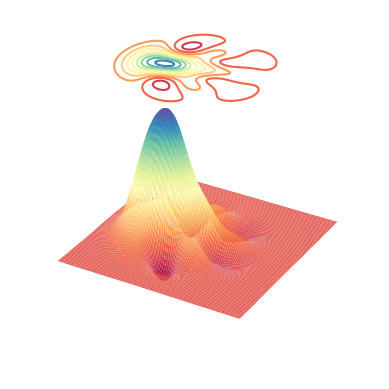

In [48]:
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_target)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=0.17)
ax.set_axis_off()
plt.savefig("T.png")
fig.show()

Learn

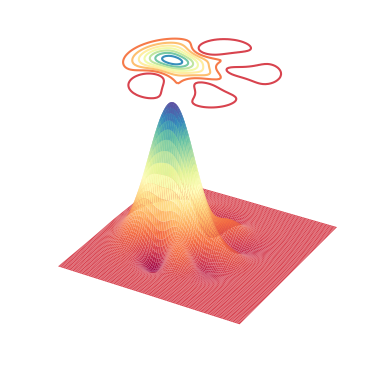

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_learnt)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=0.2) #0.2
ax.set_axis_off()
plt.savefig("L.png")
fig.show()

In [19]:
hid_params

array([{28}, {29}, {30}, {31}], dtype=object)